# Import des bibliothèques et du dataset

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, StandardScaler
from category_encoders import TargetEncoder

from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyRegressor
from scipy.stats import f_oneway
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import time
import shap

import category_encoders as ce
import missingno as msno
import seaborn as sns

In [2]:
df = pd.read_csv('/kaggle/input/dataset/outputENERGYSTARScore1stTarget.csv', sep=',')
df_onehot_final = pd.read_csv('/kaggle/input/dataset/outputOHE.csv')

# Développement du premier modèle

**Préparation des datasets train et test (target = SiteEUIWN)**

In [3]:
df_onehot_final['SiteEUIWN(kBtu/sf)'] = df['SiteEUIWN(kBtu/sf)']

X = df_onehot_final.drop(columns=['SiteEUIWN(kBtu/sf)'])
y = df_onehot_final['SiteEUIWN(kBtu/sf)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Taille du jeu d'entraînement :", X_train.shape)
print("Taille du jeu de test :", X_test.shape)

Taille du jeu d'entraînement : (1149, 190)
Taille du jeu de test : (288, 190)


In [4]:
df_onehot_final.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ElectricityProportion,NaturalGasProportion,...,ThirdLargestPropertyUseType_Restaurant,ThirdLargestPropertyUseType_Retail Store,ThirdLargestPropertyUseType_Self-Storage Facility,ThirdLargestPropertyUseType_Social/Meeting Hall,ThirdLargestPropertyUseType_Strip Mall,ThirdLargestPropertyUseType_Supermarket/Grocery Store,ThirdLargestPropertyUseType_Swimming Pool,ThirdLargestPropertyUseType_Worship Facility,ThirdLargestPropertyUseType_nan,SiteEUIWN(kBtu/sf)
count,1437.000000,1437.000000,1.437000e+03,1437.000000,1437.000000,1.437000e+03,1437.000000,1437.000000,1437.000000,1437.000000,...,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000
mean,1.066806,4.284621,1.099933e+05,14211.166319,6.737448,8.909514e+04,18755.148432,2738.859011,0.678304,0.251058,...,0.018093,0.030619,0.001392,0.004871,0.000696,0.000696,0.005567,0.000696,0.778706,76.982463
std,0.512780,6.469372,1.879230e+05,44637.995670,14.583118,1.549632e+05,47996.033477,13122.435307,0.271521,0.240670,...,0.133335,0.172344,0.037294,0.069648,0.026380,0.026380,0.074431,0.026380,0.415263,75.308203
min,1.000000,1.000000,1.128500e+04,0.000000,0.000000,5.656000e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000
25%,1.000000,1.000000,2.869600e+04,0.000000,0.000000,2.458800e+04,0.000000,0.000000,0.457970,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,37.000000
50%,1.000000,2.000000,4.671000e+04,0.000000,0.000000,4.119800e+04,0.000000,0.000000,0.681696,0.215749,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,56.099998
75%,1.000000,4.000000,1.022350e+05,0.000000,0.000000,8.648300e+04,13540.000000,0.000000,0.957552,0.453536,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,87.400002
max,9.000000,76.000000,1.952220e+06,512608.000000,89.502252,1.680937e+06,441551.000000,303910.000000,1.038722,0.970778,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,834.400024


In [5]:
df_onehot_final.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ElectricityProportion,NaturalGasProportion,...,ThirdLargestPropertyUseType_Restaurant,ThirdLargestPropertyUseType_Retail Store,ThirdLargestPropertyUseType_Self-Storage Facility,ThirdLargestPropertyUseType_Social/Meeting Hall,ThirdLargestPropertyUseType_Strip Mall,ThirdLargestPropertyUseType_Supermarket/Grocery Store,ThirdLargestPropertyUseType_Swimming Pool,ThirdLargestPropertyUseType_Worship Facility,ThirdLargestPropertyUseType_nan,SiteEUIWN(kBtu/sf)
0,1.0,12.0,88434.0,0.0,0.000000,88434.0,0.0,0.0,0.529177,0.171177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,84.300003
1,1.0,11.0,103566.0,15064.0,14.545314,83880.0,15064.0,4622.0,0.374270,0.593813,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.900002
2,1.0,41.0,956110.0,196718.0,20.574829,756493.0,0.0,0.0,0.669849,0.020204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,97.699997
3,1.0,10.0,61320.0,0.0,0.000000,61320.0,0.0,0.0,0.398590,0.260726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,113.300003
4,1.0,18.0,175580.0,62000.0,35.311539,123445.0,68009.0,0.0,0.366295,0.600689,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,118.699997


**DummyRegressor**

In [6]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)

dummy_r2 = r2_score(y_test, y_dummy_pred)
dummy_rmse = np.sqrt(mean_squared_error(y_test, y_dummy_pred))
dummy_mae = mean_absolute_error(y_test, y_dummy_pred)

print(f"R² : {dummy_r2:.3f}")
print(f"RMSE : {dummy_rmse:.3f}")
print(f"MAE : {dummy_mae:.3f}")

R² : -0.001
RMSE : 96.383
MAE : 51.239


**Ridge Regression**

In [7]:
ridge = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge_grid = GridSearchCV(ridge, param_grid, scoring='r2', cv=5, return_train_score=True)
start_time = time.time()
ridge_grid.fit(X_train, y_train)
train_time = time.time() - start_time

ridge_best = ridge_grid.best_estimator_
start_time = time.time()
ridge_y_pred = ridge_best.predict(X_test)
predict_time = time.time() - start_time

ridge_r2 = r2_score(y_test, ridge_y_pred)
ridge_rmse = mean_squared_error(y_test, ridge_y_pred, squared=False)
ridge_mae = mean_absolute_error(y_test, ridge_y_pred)

print(f"Ridge Regression - Meilleur alpha: {ridge_grid.best_params_['alpha']}")
print(f"Temps d'entraînement: {train_time:.2f} secondes")
print(f"Temps de prédiction: {predict_time:.2f} secondes")
print(f"R² (train): {ridge_grid.best_score_:.3f}")
print(f"R² (test): {ridge_r2:.3f}")
print(f"RMSE (test): {ridge_rmse:.3f}")
print(f"MAE (test): {ridge_mae:.3f}")

cv_results = pd.DataFrame(ridge_grid.cv_results_)

best_index = ridge_grid.best_index_
splits_scores = cv_results.loc[best_index, [
    f'split{i}_test_score' for i in range(5)
]]

print("Scores des splits pour le meilleur alpha :")
print(splits_scores)

stability = splits_scores.std()
print(f"\nÉcart-type des scores des splits : {stability:.3f}")

Ridge Regression - Meilleur alpha: 1
Temps d'entraînement: 1.20 secondes
Temps de prédiction: 0.01 secondes
R² (train): 0.384
R² (test): 0.473
RMSE (test): 69.904
MAE (test): 36.935
Scores des splits pour le meilleur alpha :
split0_test_score     0.33706
split1_test_score    0.371495
split2_test_score    0.288218
split3_test_score    0.564779
split4_test_score    0.358298
Name: 2, dtype: object

Écart-type des scores des splits : 0.106


**Lasso Regression**

In [8]:
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

lasso = Lasso(max_iter=10000)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2', return_train_score=True)
start_time = time.time()
lasso_grid.fit(X_train, y_train)
train_time = time.time() - start_time

lasso_best = lasso_grid.best_estimator_
start_time = time.time()
y_pred_lasso = lasso_best.predict(X_test)
predict_time = time.time() - start_time

lasso_test_r2 = r2_score(y_test, y_pred_lasso)
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_test_mae = mean_absolute_error(y_test, y_pred_lasso)

print(f"Lasso Regression - Meilleur alpha : {lasso_grid.best_params_['alpha']}")
print(f"Temps d'entraînement: {train_time:.2f} secondes")
print(f"Temps de prédiction: {predict_time:.2f} secondes")
print(f"Train R² (CV) : {lasso_grid.best_score_:.3f}")
print(f"Test R² : {lasso_test_r2:.3f}, RMSE : {lasso_test_rmse:.3f}, MAE : {lasso_test_mae:.3f}")

cv_results = pd.DataFrame(lasso_grid.cv_results_)

best_index = lasso_grid.best_index_
splits_scores = cv_results.loc[best_index, [
    f'split{i}_test_score' for i in range(5)
]]

print("Scores des splits pour le meilleur alpha :")
print(splits_scores)

stability = splits_scores.std()
print(f"\nÉcart-type des scores des splits : {stability:.3f}")

Lasso Regression - Meilleur alpha : 0.1
Temps d'entraînement: 3.42 secondes
Temps de prédiction: 0.00 secondes
Train R² (CV) : 0.380
Test R² : 0.550, RMSE : 64.615, MAE : 35.215
Scores des splits pour le meilleur alpha :
split0_test_score     0.31991
split1_test_score    0.378643
split2_test_score    0.270165
split3_test_score    0.574871
split4_test_score    0.358218
Name: 1, dtype: object

Écart-type des scores des splits : 0.116


**ElasticNet Regression**

In [9]:
elasticnet_params = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.2, 0.5, 0.8]
}

elasticnet = ElasticNet(max_iter=10000)
elasticnet_grid = GridSearchCV(elasticnet, elasticnet_params, cv=5, scoring='r2', return_train_score=True)
start_time = time.time()
elasticnet_grid.fit(X_train, y_train)
train_time = time.time() - start_time

elasticnet_best = elasticnet_grid.best_estimator_
start_time = time.time()
y_pred_elasticnet = elasticnet_best.predict(X_test)
predict_time = time.time() - start_time

elasticnet_test_r2 = r2_score(y_test, y_pred_elasticnet)
elasticnet_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_elasticnet))
elasticnet_test_mae = mean_absolute_error(y_test, y_pred_elasticnet)

print(f"ElasticNet - Meilleur alpha : {elasticnet_grid.best_params_['alpha']}")
print(f"Meilleur l1_ratio : {elasticnet_grid.best_params_['l1_ratio']}")
print(f"Temps d'entraînement: {train_time:.2f} secondes")
print(f"Temps de prédiction: {predict_time:.2f} secondes")
print(f"R² (train) : {elasticnet_grid.best_score_:.3f}")
print(f"R² (test) : {elasticnet_test_r2:.3f}, RMSE : {elasticnet_test_rmse:.3f}, MAE : {elasticnet_test_mae:.3f}")

cv_results = pd.DataFrame(elasticnet_grid.cv_results_)

best_index = elasticnet_grid.best_index_
splits_scores = cv_results.loc[best_index, [
    f'split{i}_test_score' for i in range(5)
]]

print("Scores des splits pour le meilleur alpha :")
print(splits_scores)

stability = splits_scores.std()
print(f"\nÉcart-type des scores des splits : {stability:.3f}")

ElasticNet - Meilleur alpha : 0.01
Meilleur l1_ratio : 0.8
Temps d'entraînement: 9.51 secondes
Temps de prédiction: 0.00 secondes
R² (train) : 0.392
R² (test) : 0.394, RMSE : 74.977, MAE : 38.190
Scores des splits pour le meilleur alpha :
split0_test_score    0.340497
split1_test_score    0.388406
split2_test_score    0.306436
split3_test_score    0.565526
split4_test_score     0.35739
Name: 2, dtype: object

Écart-type des scores des splits : 0.102


**TargetEncoding avec target = SiteEUIWN(kBtu/sf)**

In [10]:
df.head()

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,YearBuiltGroup,ElectricityProportion,...,Proportion_Recreation,Proportion_Technology,Proportion_Office,Proportion_Educational,Proportion_Commercial,Proportion_Healthcare,Proportion_Religious,Proportion_Industrial,ENERGYSTARScore,SiteEUIWN(kBtu/sf)
0,NonResidential,Hotel,DOWNTOWN,-5.199338,1.579968,11.390023,0.000000,0.000000,Avant 1950,0.529177,...,-5.199338,-5.199338,0.0,0.0,0.0,-5.199338,0.0,-5.199338,60.0,84.300003
1,NonResidential,Hotel,DOWNTOWN,-5.199338,1.501861,11.547974,9.620129,2.743759,1970–2000,0.374270,...,-5.199338,-5.199338,0.0,0.0,0.0,-5.199338,0.0,-5.199338,61.0,97.900002
2,NonResidential,Hotel,DOWNTOWN,-5.199338,2.365248,13.770629,12.189532,3.071527,1950–1970,0.669849,...,-5.199338,-5.199338,0.0,0.0,0.0,-5.199338,0.0,-5.199338,43.0,97.699997
3,NonResidential,Hotel,DOWNTOWN,-5.199338,1.418119,11.023878,0.000000,0.000000,Avant 1950,0.398590,...,-5.199338,-5.199338,0.0,0.0,0.0,-5.199338,0.0,-5.199338,56.0,113.300003
4,NonResidential,Hotel,DOWNTOWN,-5.199338,1.811457,12.075856,11.034906,3.592136,1970–2000,0.366295,...,-5.199338,-5.199338,0.0,0.0,0.0,-5.199338,0.0,-5.199338,75.0,118.699997


In [11]:
target_column = 'SiteEUIWN(kBtu/sf)'
categorical_columns = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuiltGroup']

X = df.drop(columns=[target_column])
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

target_encoder = TargetEncoder(cols=categorical_columns)

X_train_encoded = target_encoder.fit_transform(X_train, y_train)

X_test_encoded = target_encoder.transform(X_test)

print("Aperçu des données d'entraînement après Target Encoding :")
display(X_train_encoded.head())

print("\nAperçu des données de test après Target Encoding :")
display(X_test_encoded.head())

Aperçu des données d'entraînement après Target Encoding :


,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,YearBuiltGroup,ElectricityProportion,...,Proportion_FoodService,Proportion_Recreation,Proportion_Technology,Proportion_Office,Proportion_Educational,Proportion_Commercial,Proportion_Healthcare,Proportion_Religious,Proportion_Industrial,ENERGYSTARScore
901,75.017371,92.515422,80.787688,-5.199338,0.793602,10.684233,0.0,0.0,82.533234,0.661937,...,-5.199338,-5.199338,-5.199338,0.000000,0.000000,0.0,-5.199338,0.0,-5.199338,4.0
1405,98.949495,107.363734,55.401215,-5.199338,-5.199338,9.951992,0.0,0.0,89.347037,0.827585,...,-5.199338,-5.199338,-5.199338,0.000000,0.000000,0.0,-5.199338,0.0,-5.199338,70.4
310,75.017371,63.268610,55.401215,-5.199338,-5.199338,10.882772,0.0,0.0,74.980556,0.595217,...,-5.199338,-5.199338,-5.199338,0.688526,0.000000,0.0,-5.199338,0.0,-5.199338,96.0
1146,75.017371,73.257053,81.526984,-5.199338,-0.271787,11.717335,0.0,0.0,74.980556,0.346525,...,1.637476,-5.199338,-5.199338,0.000000,0.600797,0.0,-5.199338,0.0,-5.199338,42.2
31,75.017371,63.268610,91.249407,-5.199338,-0.271787,11.460590,0.0,0.0,74.980556,0.656571,...,-5.199338,-5.199338,-5.199338,0.461046,0.000000,0.0,-5.199338,0.0,-5.199338,57.0



Aperçu des données de test après Target Encoding :


,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,YearBuiltGroup,ElectricityProportion,...,Proportion_FoodService,Proportion_Recreation,Proportion_Technology,Proportion_Office,Proportion_Educational,Proportion_Commercial,Proportion_Healthcare,Proportion_Religious,Proportion_Industrial,ENERGYSTARScore
594,75.017371,86.151884,72.973162,-5.199338,-0.271787,10.428009,10.037494,4.22931,89.347037,0.865599,...,-5.199338,1.778943,-5.199338,0.000000,0.0,0.0,-5.199338,0.000000,-5.199338,48.6
754,75.017371,63.268610,91.014294,-5.199338,0.208505,11.205721,0.000000,0.00000,66.300535,0.289041,...,-5.199338,-5.199338,-5.199338,0.448553,0.0,0.0,-5.199338,0.360437,-5.199338,90.0
630,75.017371,86.416979,72.973162,-5.199338,1.501861,10.497946,0.000000,0.00000,66.300535,0.190895,...,-5.199338,-5.199338,-5.199338,0.000000,0.0,0.0,-5.199338,0.000000,-5.199338,98.0
1137,75.017371,47.358907,96.888997,-5.199338,0.208505,10.022292,0.000000,0.00000,66.300535,0.216698,...,-5.199338,-5.199338,-5.199338,0.000000,0.0,0.0,-5.199338,0.000000,-5.199338,70.6
905,75.017371,47.358907,72.012735,2.043115,-0.271787,10.414663,0.000000,0.00000,82.533234,0.955974,...,-5.199338,-5.199338,-5.199338,0.029084,0.0,0.0,-5.199338,0.000000,-5.199338,85.8


# Simulation d'autres modèles non linéaires

In [12]:
df.head()

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,YearBuiltGroup,ElectricityProportion,...,Proportion_Recreation,Proportion_Technology,Proportion_Office,Proportion_Educational,Proportion_Commercial,Proportion_Healthcare,Proportion_Religious,Proportion_Industrial,ENERGYSTARScore,SiteEUIWN(kBtu/sf)
0,NonResidential,Hotel,DOWNTOWN,-5.199338,1.579968,11.390023,0.000000,0.000000,Avant 1950,0.529177,...,-5.199338,-5.199338,0.0,0.0,0.0,-5.199338,0.0,-5.199338,60.0,84.300003
1,NonResidential,Hotel,DOWNTOWN,-5.199338,1.501861,11.547974,9.620129,2.743759,1970–2000,0.374270,...,-5.199338,-5.199338,0.0,0.0,0.0,-5.199338,0.0,-5.199338,61.0,97.900002
2,NonResidential,Hotel,DOWNTOWN,-5.199338,2.365248,13.770629,12.189532,3.071527,1950–1970,0.669849,...,-5.199338,-5.199338,0.0,0.0,0.0,-5.199338,0.0,-5.199338,43.0,97.699997
3,NonResidential,Hotel,DOWNTOWN,-5.199338,1.418119,11.023878,0.000000,0.000000,Avant 1950,0.398590,...,-5.199338,-5.199338,0.0,0.0,0.0,-5.199338,0.0,-5.199338,56.0,113.300003
4,NonResidential,Hotel,DOWNTOWN,-5.199338,1.811457,12.075856,11.034906,3.592136,1970–2000,0.366295,...,-5.199338,-5.199338,0.0,0.0,0.0,-5.199338,0.0,-5.199338,75.0,118.699997


In [13]:
categorical_features = df_onehot_final.select_dtypes(include=['object', 'category']).columns

target_encoder = ce.TargetEncoder(cols=categorical_features)

df_final_encoded = df_onehot_final.copy()
df_final_encoded[categorical_features] = target_encoder.fit_transform(
    df_onehot_final[categorical_features], df_onehot_final['SiteEUIWN(kBtu/sf)']
)


In [14]:
print(df_final_encoded.skew())

NumberofBuildings                                         9.815890
NumberofFloors                                            5.008990
PropertyGFATotal                                          4.835956
PropertyGFAParking                                        4.997828
PropertyGFAParkingPercentage                              2.308283
                                                           ...    
ThirdLargestPropertyUseType_Supermarket/Grocery Store    37.907783
ThirdLargestPropertyUseType_Swimming Pool                13.304136
ThirdLargestPropertyUseType_Worship Facility             37.907783
ThirdLargestPropertyUseType_nan                          -1.344181
SiteEUIWN(kBtu/sf)                                        3.582901
Length: 191, dtype: float64


In [15]:
df_final_encoded.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ElectricityProportion,NaturalGasProportion,...,ThirdLargestPropertyUseType_Restaurant,ThirdLargestPropertyUseType_Retail Store,ThirdLargestPropertyUseType_Self-Storage Facility,ThirdLargestPropertyUseType_Social/Meeting Hall,ThirdLargestPropertyUseType_Strip Mall,ThirdLargestPropertyUseType_Supermarket/Grocery Store,ThirdLargestPropertyUseType_Swimming Pool,ThirdLargestPropertyUseType_Worship Facility,ThirdLargestPropertyUseType_nan,SiteEUIWN(kBtu/sf)
0,1.0,12.0,88434.0,0.0,0.000000,88434.0,0.0,0.0,0.529177,0.171177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,84.300003
1,1.0,11.0,103566.0,15064.0,14.545314,83880.0,15064.0,4622.0,0.374270,0.593813,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.900002
2,1.0,41.0,956110.0,196718.0,20.574829,756493.0,0.0,0.0,0.669849,0.020204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,97.699997
3,1.0,10.0,61320.0,0.0,0.000000,61320.0,0.0,0.0,0.398590,0.260726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,113.300003
4,1.0,18.0,175580.0,62000.0,35.311539,123445.0,68009.0,0.0,0.366295,0.600689,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,118.699997


**Séparation du dataset et stratification du modèle**

In [16]:
df_final_encoded['target_class'] = pd.qcut(df_final_encoded['SiteEUIWN(kBtu/sf)'], q=5, labels=False)

X = df_final_encoded.drop(['SiteEUIWN(kBtu/sf)', 'target_class'], axis=1)
y = df_final_encoded['SiteEUIWN(kBtu/sf)']
y_stratified = df_final_encoded['target_class']

X_train, X_test, y_train, y_test, y_train_strat, y_test_strat = train_test_split(
    X, y, y_stratified, stratify=y_stratified, random_state=42, test_size=0.2
)


print("Taille de X_train :", X_train.shape)
print("Taille de X_test :", X_test.shape)
print("Taille de y_train :", y_train.shape)
print("Taille de y_test :", y_test.shape)

Taille de X_train : (1149, 190)
Taille de X_test : (288, 190)
Taille de y_train : (1149,)
Taille de y_test : (288,)


In [17]:
df_final_encoded.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFAParkingPercentage,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ElectricityProportion,NaturalGasProportion,...,ThirdLargestPropertyUseType_Retail Store,ThirdLargestPropertyUseType_Self-Storage Facility,ThirdLargestPropertyUseType_Social/Meeting Hall,ThirdLargestPropertyUseType_Strip Mall,ThirdLargestPropertyUseType_Supermarket/Grocery Store,ThirdLargestPropertyUseType_Swimming Pool,ThirdLargestPropertyUseType_Worship Facility,ThirdLargestPropertyUseType_nan,SiteEUIWN(kBtu/sf),target_class
count,1437.000000,1437.000000,1.437000e+03,1437.000000,1437.000000,1.437000e+03,1437.000000,1437.000000,1437.000000,1437.000000,...,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.00000
mean,1.066806,4.284621,1.099933e+05,14211.166319,6.737448,8.909514e+04,18755.148432,2738.859011,0.678304,0.251058,...,0.030619,0.001392,0.004871,0.000696,0.000696,0.005567,0.000696,0.778706,76.982463,2.00000
std,0.512780,6.469372,1.879230e+05,44637.995670,14.583118,1.549632e+05,47996.033477,13122.435307,0.271521,0.240670,...,0.172344,0.037294,0.069648,0.026380,0.026380,0.074431,0.026380,0.415263,75.308203,1.41569
min,1.000000,1.000000,1.128500e+04,0.000000,0.000000,5.656000e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,0.00000
25%,1.000000,1.000000,2.869600e+04,0.000000,0.000000,2.458800e+04,0.000000,0.000000,0.457970,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,37.000000,1.00000
50%,1.000000,2.000000,4.671000e+04,0.000000,0.000000,4.119800e+04,0.000000,0.000000,0.681696,0.215749,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,56.099998,2.00000
75%,1.000000,4.000000,1.022350e+05,0.000000,0.000000,8.648300e+04,13540.000000,0.000000,0.957552,0.453536,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,87.400002,3.00000
max,9.000000,76.000000,1.952220e+06,512608.000000,89.502252,1.680937e+06,441551.000000,303910.000000,1.038722,0.970778,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,834.400024,4.00000


**Random Forest**

In [18]:
rf_model = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid_search = GridSearchCV(
    rf_model,
    param_grid=rf_params,
    cv=stratified_kfold.split(X_train, y_train_strat),
    scoring='r2',
    n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)

print("Random Forest Best Params:", rf_grid_search.best_params_)
print("Random Forest Best R2 (CV):", rf_grid_search.best_score_)

Random Forest Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Best R2 (CV): 0.48799427597762496


**Fine-Tuning**

In [19]:
best_max_depth = rf_grid_search.best_params_['max_depth']

rf_fine_params = {
    'n_estimators': [
        max(10, rf_grid_search.best_params_['n_estimators'] - 50), 
        rf_grid_search.best_params_['n_estimators'], 
        rf_grid_search.best_params_['n_estimators'] + 50
    ],
    'max_depth': [
        max(1, best_max_depth - 5) if best_max_depth and best_max_depth != None else 20,
        best_max_depth, 
        best_max_depth + 5 if best_max_depth and best_max_depth != None else 30
    ] if best_max_depth else [None, 20, 30],
    'min_samples_split': [
        max(2, rf_grid_search.best_params_['min_samples_split'] - 2), 
        rf_grid_search.best_params_['min_samples_split'], 
        rf_grid_search.best_params_['min_samples_split'] + 2
    ]
}

rf_fine_params = {k: [v for v in vals if v is not None] for k, vals in rf_fine_params.items()}
print(rf_fine_params)
rf_fine_tuning = GridSearchCV(
    rf_model,
    param_grid=rf_fine_params,
    cv=stratified_kfold.split(X_train, y_train_strat),
    scoring='r2',
    n_jobs=-1
)

rf_fine_tuning.fit(X_train, y_train)

print("Random Forest Fine-Tuned Params:", rf_fine_tuning.best_params_)
print("Random Forest Fine-Tuned R2:", rf_fine_tuning.best_score_)

{'n_estimators': [150, 200, 250], 'max_depth': [20, 30], 'min_samples_split': [2, 2, 4]}
Random Forest Fine-Tuned Params: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 250}
Random Forest Fine-Tuned R2: 0.49204965855250277


**GradientBoosting**

In [20]:
gb_model = GradientBoostingRegressor(random_state=42, validation_fraction=0.2, n_iter_no_change=10)

gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gb_grid_search = GridSearchCV(
    gb_model,
    param_grid=gb_params,
    cv=stratified_kfold.split(X_train, y_train_strat),
    scoring='r2',
    n_jobs=-1
)

gb_grid_search.fit(X_train, y_train)

print("Gradient Boosting Best Params:", gb_grid_search.best_params_)
print("Gradient Boosting Best R2 (CV):", gb_grid_search.best_score_)

Gradient Boosting Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Gradient Boosting Best R2 (CV): 0.45637984779864027


**Fine-Tuning**

In [21]:
gb_fine_params = {
    'n_estimators': [gb_grid_search.best_params_['n_estimators'] - 50, gb_grid_search.best_params_['n_estimators'], gb_grid_search.best_params_['n_estimators'] + 50],
    'learning_rate': [gb_grid_search.best_params_['learning_rate'] * 0.5, gb_grid_search.best_params_['learning_rate'], gb_grid_search.best_params_['learning_rate'] * 1.5],
    'max_depth': [gb_grid_search.best_params_['max_depth'] - 1, gb_grid_search.best_params_['max_depth'], gb_grid_search.best_params_['max_depth'] + 1]
}

gb_fine_tuning = GridSearchCV(
    gb_model,
    param_grid=gb_fine_params,
    cv=stratified_kfold.split(X_train, y_train_strat),
    scoring='r2',
    n_jobs=-1
)

gb_fine_tuning.fit(X_train, y_train)

print("Gradient Boosting Fine-Tuned Params:", gb_fine_tuning.best_params_)
print("Gradient Boosting Fine-Tuned R2:", gb_fine_tuning.best_score_)

gb_best = gb_fine_tuning.best_estimator_
y_pred_test = gb_best.predict(X_test)

test_r2 = r2_score(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)

print("Gradient Boosting R2 sur le jeu de test :", test_r2)
print("Gradient Boosting RMSE sur le jeu de test :", test_mse)

Gradient Boosting Fine-Tuned Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Gradient Boosting Fine-Tuned R2: 0.4588151602779399
Gradient Boosting R2 sur le jeu de test : 0.34823101579463356
Gradient Boosting RMSE sur le jeu de test : 3487.0632947190497


**TargetEncoding**

In [22]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns

target_encoder = ce.TargetEncoder(cols=categorical_features)

df_final_encoded = df.copy()
df_final_encoded[categorical_features] = target_encoder.fit_transform(
    df[categorical_features], df['SiteEUIWN(kBtu/sf)']
)

scaler = StandardScaler()
df_final_scaled = scaler.fit_transform(df_final_encoded) 
df_final_encoded = pd.DataFrame(df_final_scaled, columns=df_final_encoded.columns)

df_final_encoded['target_class'] = pd.qcut(df_final_encoded['SiteEUIWN(kBtu/sf)'], q=5, labels=False)

X = df_final_encoded.drop(['SiteEUIWN(kBtu/sf)', 'target_class'], axis=1)
y = df_final_encoded['SiteEUIWN(kBtu/sf)']
y_stratified = df_final_encoded['target_class']

X_train, X_test, y_train, y_test, y_train_strat, y_test_strat = train_test_split(
    X, y, y_stratified, stratify=y_stratified, random_state=42, test_size=0.2
)


print("Taille de X_train :", X_train.shape)
print("Taille de X_test :", X_test.shape)
print("Taille de y_train :", y_train.shape)
print("Taille de y_test :", y_test.shape)

Taille de X_train : (1149, 25)
Taille de X_test : (288, 25)
Taille de y_train : (1149,)
Taille de y_test : (288,)


In [23]:
rf_model = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid_search = GridSearchCV(
    rf_model,
    param_grid=rf_params,
    cv=stratified_kfold.split(X_train, y_train_strat),
    scoring='r2',
    n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)

print("Random Forest Best Params:", rf_grid_search.best_params_)
print("Random Forest Best R2 (CV):", rf_grid_search.best_score_)

Random Forest Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Best R2 (CV): 0.6109785150259577


In [24]:
best_max_depth = rf_grid_search.best_params_['max_depth']

rf_fine_params = {
    'n_estimators': [
        max(10, rf_grid_search.best_params_['n_estimators'] - 50), 
        rf_grid_search.best_params_['n_estimators'], 
        rf_grid_search.best_params_['n_estimators'] + 50
    ],
    'max_depth': [
        max(1, best_max_depth - 5) if best_max_depth and best_max_depth != None else 20,
        best_max_depth, 
        best_max_depth + 5 if best_max_depth and best_max_depth != None else 30
    ] if best_max_depth else [None, 20, 30],
    'min_samples_split': [
        max(2, rf_grid_search.best_params_['min_samples_split'] - 2), 
        rf_grid_search.best_params_['min_samples_split'], 
        rf_grid_search.best_params_['min_samples_split'] + 2
    ]
}

rf_fine_params = {k: [v for v in vals if v is not None] for k, vals in rf_fine_params.items()}

rf_fine_tuning = GridSearchCV(
    rf_model,
    param_grid=rf_fine_params,
    cv=stratified_kfold.split(X_train, y_train_strat),
    scoring='r2',
    n_jobs=-1
)

rf_fine_tuning.fit(X_train, y_train)

print("Random Forest Fine-Tuned Params:", rf_fine_tuning.best_params_)
print("Random Forest Fine-Tuned R2:", rf_fine_tuning.best_score_)

Random Forest Fine-Tuned Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Fine-Tuned R2: 0.6109785150259577


In [25]:
gb_model = GradientBoostingRegressor(random_state=42, validation_fraction=0.2, n_iter_no_change=10)

gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gb_grid_search = GridSearchCV(
    gb_model,
    param_grid=gb_params,
    cv=stratified_kfold.split(X_train, y_train_strat),
    scoring='r2',
    n_jobs=-1
)

gb_grid_search.fit(X_train, y_train)

print("Gradient Boosting Best Params:", gb_grid_search.best_params_)
print("Gradient Boosting Best R2 (CV):", gb_grid_search.best_score_)

Gradient Boosting Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Gradient Boosting Best R2 (CV): 0.5555038949299403


In [26]:
gb_fine_params = {
    'n_estimators': [gb_grid_search.best_params_['n_estimators'] - 50, gb_grid_search.best_params_['n_estimators'], gb_grid_search.best_params_['n_estimators'] + 50],
    'learning_rate': [gb_grid_search.best_params_['learning_rate'] * 0.5, gb_grid_search.best_params_['learning_rate'], gb_grid_search.best_params_['learning_rate'] * 1.5],
    'max_depth': [gb_grid_search.best_params_['max_depth'] - 1, gb_grid_search.best_params_['max_depth'], gb_grid_search.best_params_['max_depth'] + 1]
}

gb_fine_tuning = GridSearchCV(
    gb_model,
    param_grid=gb_fine_params,
    cv=stratified_kfold.split(X_train, y_train_strat),
    scoring='r2',
    n_jobs=-1
)

gb_fine_tuning.fit(X_train, y_train)

print("Gradient Boosting Fine-Tuned Params:", gb_fine_tuning.best_params_)
print("Gradient Boosting Fine-Tuned R2:", gb_fine_tuning.best_score_)

gb_best = gb_fine_tuning.best_estimator_
y_pred_test = gb_best.predict(X_test)

test_r2 = r2_score(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)

print("Gradient Boosting R2 sur le jeu de test :", test_r2)
print("Gradient Boosting MSE sur le jeu de test :", test_mse)

Gradient Boosting Fine-Tuned Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Gradient Boosting Fine-Tuned R2: 0.5555038949299403
Gradient Boosting R2 sur le jeu de test : 0.3810525114485066
Gradient Boosting MSE sur le jeu de test : 0.5843024502110503


**Récupération des meilleurs modèles**

In [27]:
rf_best = rf_grid_search.best_estimator_
gb_best = gb_fine_tuning.best_estimator_

rf_predictions = rf_best.predict(X_test)
gb_predictions = gb_best.predict(X_test)

rf_r2 = r2_score(y_test, rf_predictions)
gb_r2 = r2_score(y_test, gb_predictions)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))


rf_mae = mean_absolute_error(y_test, rf_predictions)
gb_mae = mean_absolute_error(y_test, gb_predictions)

print("RANDOM FOREST :")
print(f"Random Forest R2 sur le test set: {rf_r2}")
print(f"Random Forest RMSE sur le test set: {rf_rmse}")
print(f"Random Forest MAE: {rf_mae}")
print("GRADIENT BOOSTING :")
print(f"Gradient Boosting R2 sur le test set: {gb_r2}")
print(f"Gradient Boosting RMSE sur le test set: {gb_rmse}")
print(f"Gradient Boosting MAE: {gb_mae}")

RANDOM FOREST :
Random Forest R2 sur le test set: 0.45654043278380196
Random Forest RMSE sur le test set: 0.7162680353883046
Random Forest MAE: 0.37095807794436425
GRADIENT BOOSTING :
Gradient Boosting R2 sur le test set: 0.3810525114485066
Gradient Boosting RMSE sur le test set: 0.7643967884620201
Gradient Boosting MAE: 0.40325301507547817


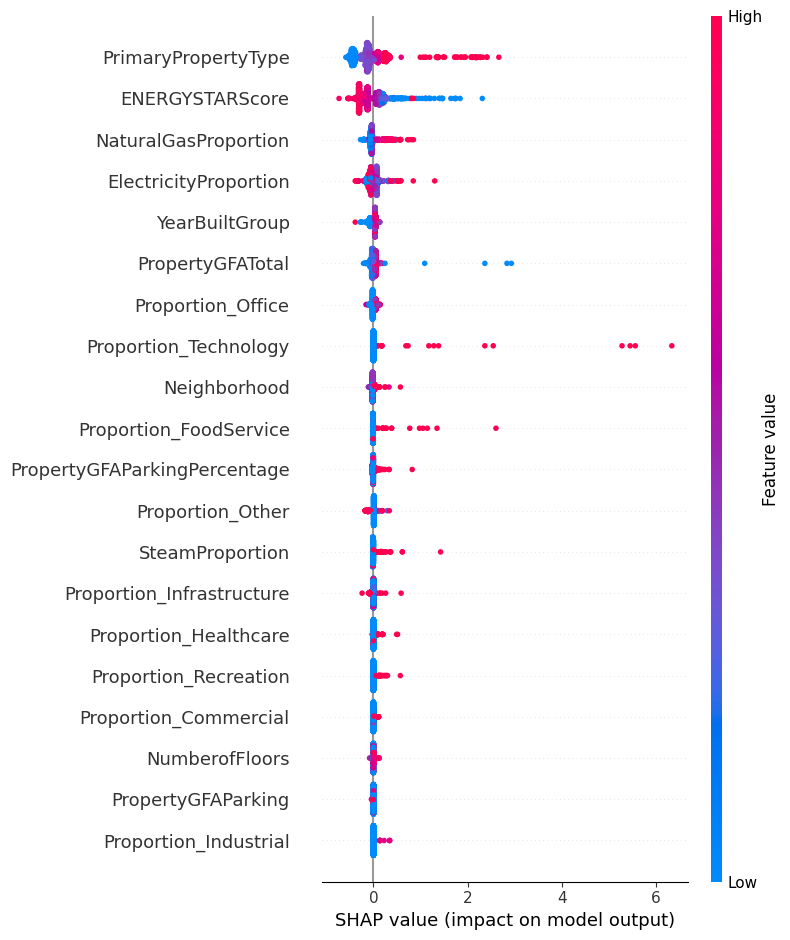

In [28]:
explainer = shap.Explainer(gb_best, X_train)  
shap_values = explainer(X_train)
shap.initjs()
shap.summary_plot(shap_values, X_train)

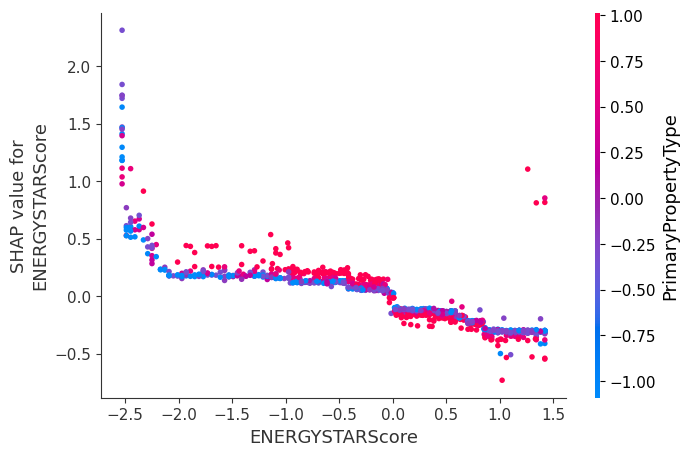

In [29]:
shap.dependence_plot('ENERGYSTARScore', shap_values.values, X_train)

In [30]:
shap.force_plot(
    explainer.expected_value,
    shap_values.values[0, :],
    X_train.iloc[0, :],
)